In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import pathlib
import re
import json
import math
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

symbols_list_file_name = "binance_BTC_from_2019_05_01_to_2022_04_30.json"
with open(symbols_list_file_name, "r") as f:
    symbols_list = json.load(f)

input_folder_name = "full_returns_winsorised"

In [ ]:
symbol = 'adabtc'
file_name = symbol + '.csv.gz'
path = os.path.join(os.getcwd(), input_folder_name, file_name)
df = pd.read_csv(path, compression='gzip')

nums = df.index
first_day_first_minute = dt.datetime(2019, 5, 1)
initial_time = dt.datetime.utcfromtimestamp(0)
theoretical_first_minute = math.floor(
    (first_day_first_minute - initial_time) / dt.timedelta(minutes=1)
)
dt_index = pd.to_datetime(theoretical_first_minute + nums, unit="m")
df.set_index(dt_index, inplace=True)
squared_returns = df.pow(2)
volas = squared_returns.groupby(pd.Grouper(freq="H")).sum()

In [2]:
# CAREFUL TO SEE IF ALREADY SHIFTED HOUR
train_size = 731 * 24
volas_train = volas[:train_size]
volas_train_rolled = volas_train.rolling(24).sum()
volas_train_rolled.dropna(inplace=True)
volas_train_rolled.index += pd.DateOffset(hours=1) # need to do this on test as well 

In [46]:
volas

,adabtc
2019-05-01 00:00:00,0.000088
2019-05-01 01:00:00,0.000053
2019-05-01 02:00:00,0.000024
2019-05-01 03:00:00,0.000030
2019-05-01 04:00:00,0.000046
...,...
2022-04-30 19:00:00,0.000015
2022-04-30 20:00:00,0.000016
2022-04-30 21:00:00,0.000010
2022-04-30 22:00:00,0.000098


In [47]:
volas_daily = volas.groupby(pd.Grouper(freq="D")).sum()

In [49]:
volas_daily.rename(columns={symbol : 'd'}, inplace=True)

In [63]:
train_size = 731 + 184
volas_daily_train = volas_daily[:train_size]

In [84]:
volas_daily_train['w'] = volas_daily_train['d'].rolling(7).sum()

c:\users\wang-\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
volas_daily_train['m'] = volas_daily_train['d'].rolling(30).sum()

c:\users\wang-\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
volas_daily_train

,d,w,m
2019-05-01,0.000911,NaN,NaN
2019-05-02,0.000645,NaN,NaN
2019-05-03,0.001271,NaN,NaN
2019-05-04,0.001277,NaN,NaN
2019-05-05,0.000698,NaN,NaN
...,...,...,...
2021-10-27,0.001799,0.005400,0.023111
2021-10-28,0.001585,0.005722,0.024039
2021-10-29,0.000728,0.005759,0.024168
2021-10-30,0.000385,0.005745,0.024191


In [87]:
import statsmodels.api as sm

In [88]:
volas_daily_train['d_next'] = volas_daily_train['d'].shift(-1)

c:\users\wang-\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [89]:
volas_daily_train.dropna(inplace=True)

c:\users\wang-\appdata\local\programs\python\python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [90]:
X = volas_daily_train[['d', 'w', 'm']]
X = sm.add_constant(X)

In [91]:
y = volas_daily_train['d_next']

In [92]:
mod = sm.OLS(y, X)

In [93]:
res = mod.fit()

In [94]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 d_next   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     431.0
Date:                Sun, 21 Aug 2022   Prob (F-statistic):          2.87e-172
Time:                        11:47:49   Log-Likelihood:                 4719.9
No. Observations:                 885   AIC:                            -9432.
Df Residuals:                     881   BIC:                            -9413.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   7.64e-05      2.694      0.007    5.59e-05       0.000
d              0.5827      0.034     16.930      0.000       0.515       0.650
w              0.0319      0.007      4.314      0.000       0.017       0.046
m              0.0028      0.002      1.716      0.086      -0.000       0.006
==============================================================================
Omnibus:                      463.634   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4381.579
Skew:                           2.196   Prob(JB):                         0.00
Kurtosis:                      12.977   Cond. No.                         885.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
predictions = res.predict()

In [97]:
df_res = volas_daily_train.copy(deep=True)
df_res["pred"] = predictions
((df_res['d_next'] - df_res['pred']) ** 2).sum()

0.001207989192533429

<AxesSubplot:>

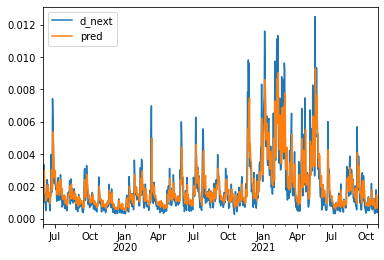

In [102]:
df_res[['d_next', 'pred']].plot()

In [ ]:
# i need to do d = 1, w = 7, m = 30 things

In [ ]:
# arghhh i have to write it myself DWM (and potentially others)

